# Convolutional Neural Network (CNN) for Image Classification

### Überblick

- *Convolutional Neural Network* (CNN): Unterart der neuronalen Netze
- *Convolutional* englisch für Faltung
- CNN orientiert sich an der Funktionsweise des visuellen Kortex des menschlichen Gehirns
- Entworfen von Yann LeCun

### Aufbau

- Abwechselnd *Convolutional Layer* und *Pooling Layer*, am Ende *Fully Connected Layer*

### Convolutional Layer

![Faltung](./img/2.gif)

- Generiert aus Faltung von Bild mit Filter/Kernel eine *Feature map*
- Parameter:
    - Stride: 1
    - Filtersize: 3x3
    - Padding: valid

![Filter](./img/cnn_filters.png)

- Filter ermöglichen Finden unterschiedlicher Muster wie bspw. Kanten

### Max-Pooling Layer

![Pooling](./img/3.png)

- Größter Wert wird in neue Matrix übertragen
- Teilbereiche werden zusammengefasst  
→ Abstrahiert Features aus Feature map  
- Parameter:
    - Stride: 2
    - Windowsize: 2x2  
- Andere: Summe, Durchschnitt

### Fully-Connected Layer

- Gefundene Muster werden Klassen zugeordnet

### Implementierung eines CNNs zur Klassifikation von Früchten (Python und Keras)

In [1]:
import numpy as np

from keras.datasets import cifar100
from keras.utils import to_categorical
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from keras.callbacks import TensorBoard
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

from time import time

Using TensorFlow backend.


- CIFAR100-Datensatz 
- **60.000 farbigen Bildern** aufgeteilt in **50.000 Trainingsbilder** und **10.000 Testbildern** mit Kategorien und Subkategorien

In [2]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

- Wir reduzieren unsere Daten auf die Kategorien: **Apple, Orange, Pear** über die ID: Apple = 0, Orange = 53, Pear = 57

In [3]:
# Wir untersuchen, ob es sich bei einem Eintrag der Trainings-Labels um eines der Früchte
# (0 = Apfel, 1 = Orange, 2 = Birne) handelt.
# Falls ja, fügen wir dessen Index einem Array hinzu.
indices_train = np.where((y_train == 0) | (y_train == 53) | (y_train == 57))[0]
indices_test = np.where((y_test == 0) | (y_test == 53) | (y_test == 57))[0]

# Wir reduzieren unsere Trainings-, Test-Labels und -Daten auf alle die, der Früchte.
y_train = np.array(y_train[indices_train])
y_test = np.array(y_test[indices_test])

x_train = x_train[indices_train]
x_test = x_test[indices_test]

# Für die Konvertierung unserer Label-Vektoren in Binäre-Klassenmatrizen, ändern wir alle ursprünglichen
# Trainings- und Test-Labels in die Werte 0-2 mittels lambda-Funktionen.
y_train = np.array(list(map(lambda i: [1] if i == 53 else ([2] if i == 57 else [0]), y_train)))
y_test = np.array(list(map(lambda i: [1] if i == 53 else ([2] if i == 57 else [0]), y_test)))


# Die Konvertierung unser Label-Vektoren in Binäre-Klassenmatrizen wird für unseren Datensatz benötigt.
# Die Binäre-Klassenmatrix entspricht dabei der One-Hote-Notation.
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

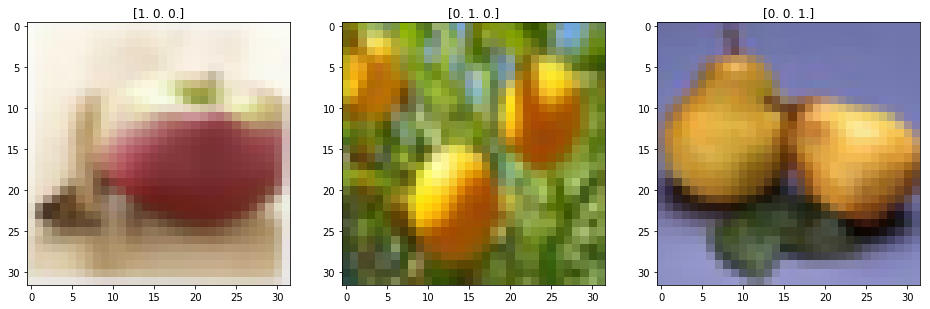

In [4]:
# Dafür plotten wir jeweils 1 Bild der drei Kategorien mit ihren One-Hot-Labeln.
fig = plt.figure(figsize=(16, 6))

apple = fig.add_subplot(1, 3, 1)
apple.set_title(y_train[0])
apple.imshow(x_train[0])

orange = fig.add_subplot(1, 3, 2)
orange.set_title(y_train[1])
orange.imshow(x_train[1])

pear = fig.add_subplot(1, 3, 3)
pear.set_title(y_train[6])
pear.imshow(x_train[6])

plt.show()

In [5]:
# Wir müssen zuvor unsere Bilddaten in Float-Datentypen casten, dass wir Gleitkommazahlen bekommen. 
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Konvertieren der RGB-Werte in Werte zwischen [0;1]
x_train /= 255
x_test /= 255

# Splitten Trainingsdatensatz in Training und Validierung
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.20)

### Erste Ergebnisse

![Training-accuracy](./img/acc.png)

![Validation-Losses](./img/val_loss.png)


In [6]:
# Wir definieren unser Model über einen Stapel von Schichten. Hierzu initialisieren wir unser sequentialles Modell.
model = Sequential()

model.add(
    Conv2D(32, 3, activation='relu', data_format="channels_last", input_shape=(32, 32, 3), strides=1, padding="valid",
           kernel_initializer="he_uniform"))
model.add(MaxPooling2D(2))
model.add(Dropout(0.2))

model.add(
    Conv2D(32, 3, activation='relu', strides=1, padding="valid", kernel_initializer="he_uniform"))
model.add(MaxPooling2D(2))
model.add(Dropout(0.3))

model.add(
    Conv2D(32, 3, activation='relu', strides=1, padding="valid", kernel_initializer="he_uniform"))
model.add(MaxPooling2D(2))
model.add(Dropout(0.4))

# Dient der Dimensionsreduktion. Wird für Verwendung von Dense Layern benötigt.
model.add(Flatten())

# Voll verbundene Neuronen.
model.add(Dense(1024, activation='relu'))
model.add(Dense(3, activation='softmax'))

# Konfiguration der Trainingsparameter.
model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.001), metrics=['accuracy'])

In [7]:
# Initialisieren unseres Tensorboard-Callbacks zur späteren Visualisierung unserer Metriken.
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

history = model.fit(x_train, y_train, epochs=50, validation_data=(x_valid, y_valid), callbacks=[tensorboard])

Train on 1200 samples, validate on 300 samples
Epoch 1/50
1200/1200 [==============================] - 2s 1ms/step - loss: 0.2126 - acc: 0.4692 - val_loss: 0.1764 - val_acc: 0.6633
Epoch 2/50
1200/1200 [==============================] - 1s 994us/step - loss: 0.1688 - acc: 0.6308 - val_loss: 0.1590 - val_acc: 0.6567
Epoch 3/50
1200/1200 [==============================] - 1s 1ms/step - loss: 0.1464 - acc: 0.6725 - val_loss: 0.1412 - val_acc: 0.7367
Epoch 4/50
1200/1200 [==============================] - 2s 1ms/step - loss: 0.1320 - acc: 0.7108 - val_loss: 0.1342 - val_acc: 0.7433
Epoch 5/50
1200/1200 [==============================] - 1s 1ms/step - loss: 0.1275 - acc: 0.7258 - val_loss: 0.1355 - val_acc: 0.7100
Epoch 6/50
1200/1200 [==============================] - 1s 922us/step - loss: 0.1221 - acc: 0.7325 - val_loss: 0.1316 - val_acc: 0.7233
Epoch 7/50
1200/1200 [==============================] - 1s 1ms/step - loss: 0.1190 - acc: 0.7450 - val_loss: 0.1283 - val_acc: 0.7367
Epoch 8/50


In [8]:
# Ausgeben der Test-accuracy
score = model.evaluate(x_test, y_test)

print("Test-accuracy: " + str(score[1]*100) + "%")

300/300 [==============================] - 0s 290us/step
Test-accuracy: 81.99999992052715%


In [9]:
# Vorhersagen der Testdaten-Labels.
y_pred = model.predict_classes(x_test, verbose=0)

# Umkehren der binären Klassenmatrix zu kategorischen Vektoren für Confusion Matrix.
y_test_rev = [np.argmax(y, axis=None, out=None) for y in y_test]

# Berechnen der Confusion Matrix
print(confusion_matrix(y_test_rev, y_pred))

[[83  1 16]
 [ 2 79 19]
 [12  4 84]]


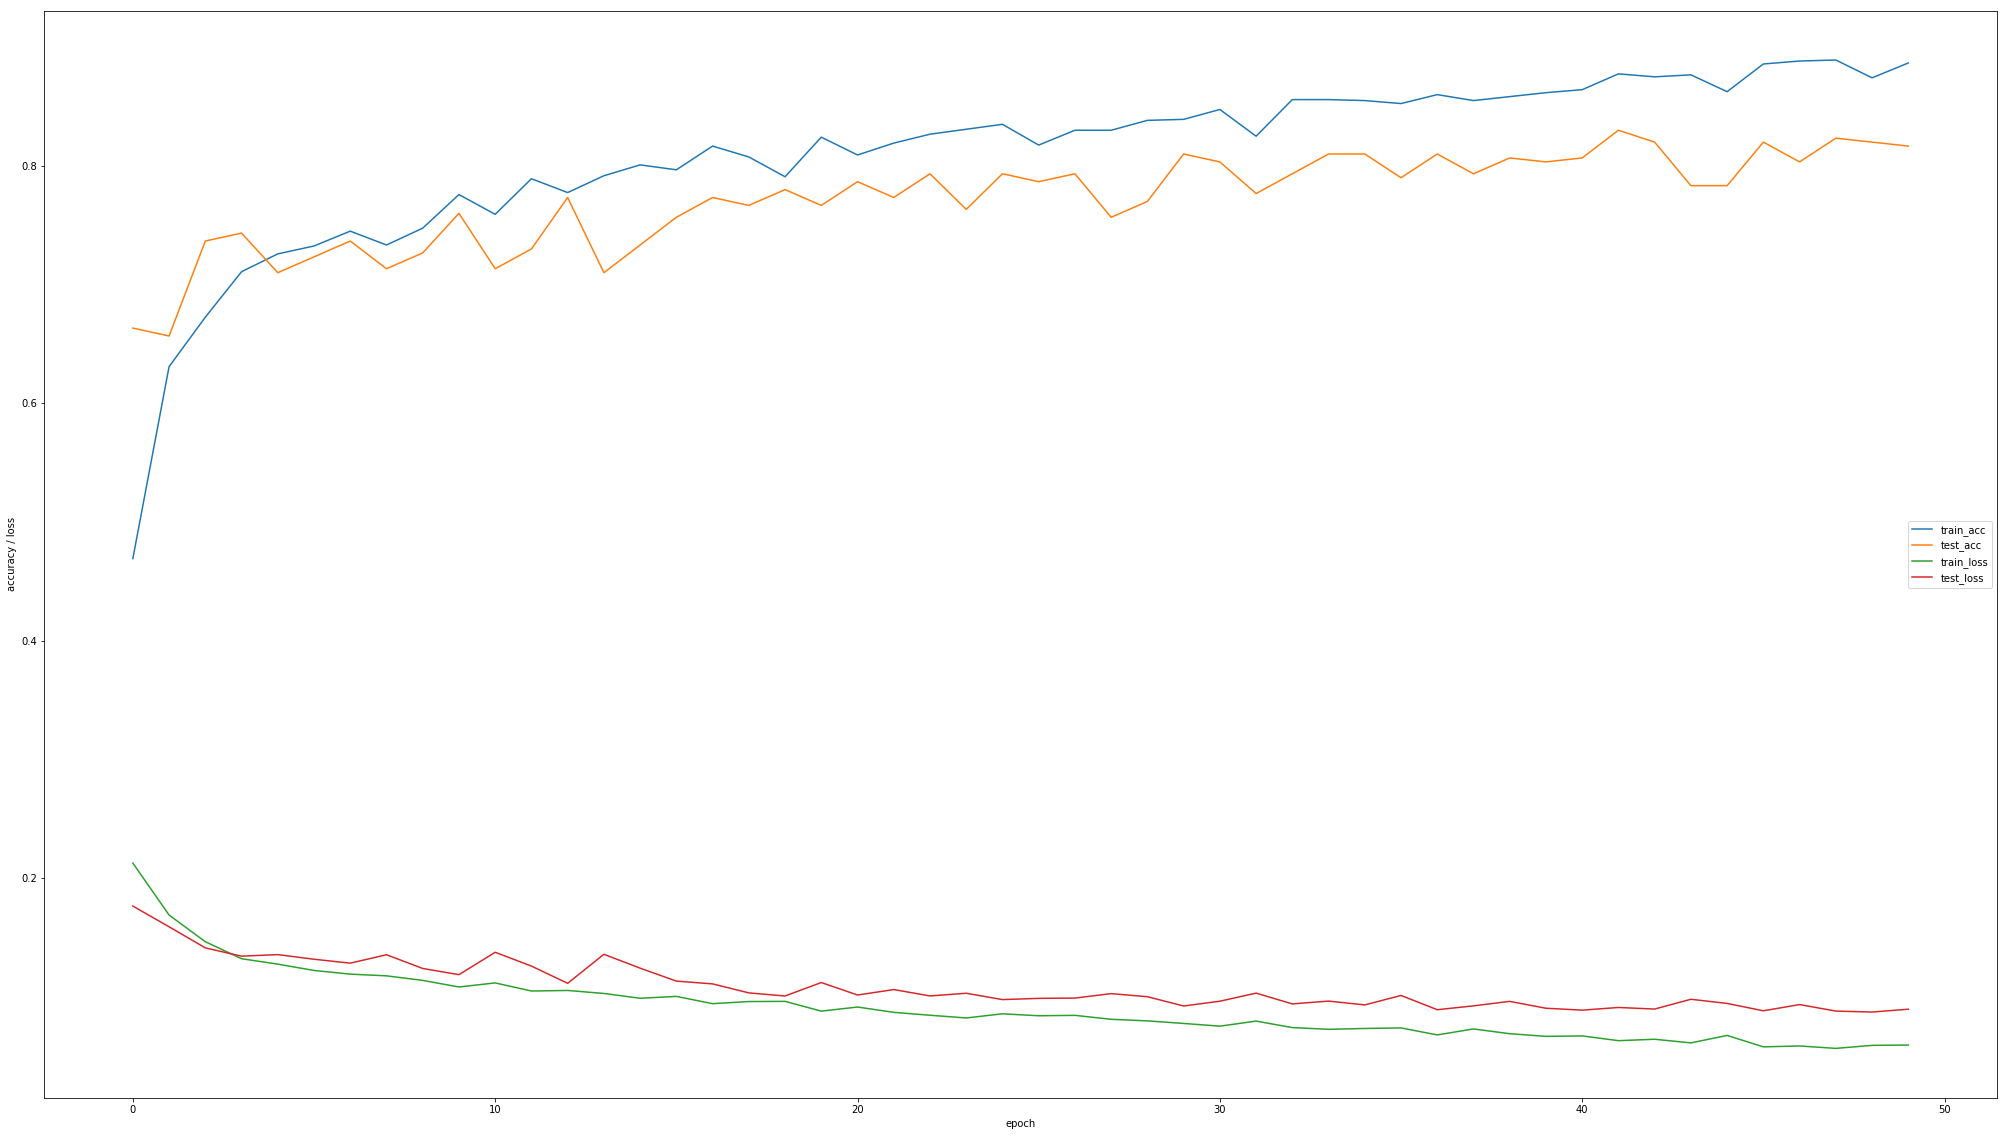

In [12]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('accuracy / loss')
plt.xlabel('epoch')
plt.legend(['train_acc', 'test_acc', 'train_loss', 'test_loss'], loc='center right')
plt.rcParams["figure.figsize"] = (35, 20)
plt.show()

In [11]:
model.save("model.h5")